---
abbreviations:
  GEMM: GEneral Matrix-Matrix multiplication
  GEMV: General Matrix-Vector multiply, a special case of GEMM
  WMMA: Warp-level matrix operations
---
# PHASE 1: FOUNDATIONAL NEURONS & BACKPROP

In [1]:
import sys

sys.version

'3.14.0 free-threading build (main, Oct 28 2025, 12:10:48) [Clang 20.1.4 ]'

# Environment preparation

In [2]:
# bash
venv_name="slm_from_scratch"
venv_path="${HOME}/venv/${venv_name}"

create_jupyter_venv -p 3.14t -n "${venv_name}"

uv pip install -p "${venv_path}" \
    matplotlib \
    numpy \
    seaborn

# remove_jupyter_venv "${venv_name}"

Using CPython 3.14.0+freethreaded interpreter at: /home/commi/.local/bin/python3.14t
Creating virtual environment at: /home/commi/venv/slm_from_scratch
Activate with: source /home/commi/venv/slm_from_scratch/bin/activate
Using Python 3.14.0 environment at: /home/commi/venv/slm_from_scratch
Resolved 29 packages in 728ms                                        
Prepared 3 packages in 2.60s                                             
Installed 29 packages in 55ms                               
 + asttokens==3.0.1
 + comm==0.2.3
 + debugpy==1.8.19
 + decorator==5.2.1
 + executing==2.2.1
 + ipykernel==7.1.0
 + ipython==9.8.0
 + ipython-pygments-lexers==1.1.1
 + jedi==0.19.2
 + jupyter-client==8.7.0
 + jupyter-core==5.9.1
 + matplotlib-inline==0.2.1
 + nest-asyncio==1.6.0
 + packaging==25.0
 + parso==0.8.5
 + pexpect==4.9.0
 + platformdirs==4.5.1
 + prompt-toolkit==3.0.52
 + psutil==7.1.3
 + ptyprocess==0.7.0
 + pure-eval==0.2.3
 + pygments==2.19.2
 + python-dateutil==2.9.0.post0
 + pyzmq==2

**The Core Idea**: A neural network is just a mathematical function that can be represented as a computational graph. The "learning" happens by adjusting the parameters of this function to minimize some error.

# **1. Forward Pass**

We begin with the absolute building block of all deep learning: **the single neuron**.

# 1.1 The Mathematical Neuron

A neuron computes:

```{math}
z = \mathbf{w}^\top \mathbf{x} + b
```

```{math}
:label: eq:activation_general
a = \sigma(z)
```

Where:
- $\mathbf{x} \in \mathbb{R}^d$ is the input vector,
- $\mathbf{w} \in \mathbb{R}^d$ is the weight vector,
- $b \in \mathbb{R}$ is the bias,
- $\sigma$ is a nonlinear activation function (e.g., ReLU, tanh),
- $a$ is the output (activation).

This is **not** a biological metaphor—it is a differentiable function that enables composition and gradient flow.


```{mermaid}
graph LR
    X --> mul
    W.T --> mul
    b --> add
    mul --> add
    add --> z
```

Think about processing one input vector vs many inputs:

**Single input**: $[x_1, x_2, x_3]$ with weights $[\theta_1, \theta_2, \theta_3]$  
$\text {output} = x_1\theta_1 + x_2\theta_2 + x_3\theta_3 + b$

**Multiple inputs (as matrix)**: 
```
Inputs: [ [x₁₁, x₁₂, x₁₃],   Weights: [𝜃₁, 𝜃₂, 𝜃₃]ᵀ
          [x₂₁, x₂₂, x₂₃],
          [x₃₁, x₃₂, x₃₃] ]
```

What linear algebra operation would efficiently compute all outputs at once? Matrix multiplication.

# 1.2 What is GEMM?

GEMM stands for **GE**neral **M**atrix-**M**atrix multiplication. It is a foundational linear algebra operation defined as:

```{math}
C = \alpha \cdot A \cdot B + \beta \cdot C
```

where:
- {math}`A \in \mathbb{R}^{m \times k}`, {math}`B \in \mathbb{R}^{k \times n}`, {math}`C \in \mathbb{R}^{m \times n}`
- {math}`\alpha, \beta` are scalar coefficients (often {math}`\alpha = 1, \beta = 0` in deep learning)
- The operation computes all pairwise dot products between rows of {math}`A` and columns of {math}`B`

In linear algebra and deep learning, a **dot product** is an operation between two vectors of the same dimension, resulting in a single scalar:

$$a \cdot b = \sum_{i=1}^{n} a_i b_i$$

When we speak of **matrix multiplication** (2$C = AB$), we are indeed performing "pairwise dot products" between the **rows** of $A$ and the **columns** of $B$. However, it is critical to distinguish this from an **element-wise (Hadamard) product**, which is also a "pairwise" operation but occurs between corresponding elements of two matrices of the identical shape ($A \odot B$).

## Pairwise Dot Products

Essentially, **pairwise dot products** is a way of describing the "all-vs-all" calculation that happens during matrix multiplication.

While a single dot product tells you the relationship between two specific vectors, pairwise dot products tell you the relationship between **every possible pair of vectors** from two different sets.

In the context of the GEMM formula {math}`C = A \cdot B`, think of matrix $A$ as a stack of horizontal rows and matrix $B$ as a collection of vertical columns.

1. **The Inputs:** Matrix $A$ has $m$ rows, and Matrix $B$ has $n$ columns.
2. **The Matching:** To find a specific value in the resulting matrix $C$, you take one row from $A$ and "dot" it with one column from $B$.
3. **The "Pairwise" Result:** Because you repeat this for every row combined with every column, you end up with $m \times n$ individual dot products.

If Matrix $A$ contains vectors $\{a_1, a_2\}$ and Matrix $B$ contains vectors $\{b_1, b_2\}$, the **pairwise dot products** are:

```{math}
C = 
\begin{pmatrix}
a_1 \cdot b_1 & a_1 \cdot b_2 \\
a_2 \cdot b_1 & a_2 \cdot b_2
\end{pmatrix}
```

You’ll often hear this term when discussing **Attention Mechanisms** (like in Transformers). 

> When a model calculates "Self-Attention," it is performing pairwise dot products between every word (vector) in a sentence and every other word in that same sentence to see how much they relate to one another.

**Summary Table**

| Concept | Operation | Definition | Result |
| --- | --- | --- | --- |
| **Dot Product** | $a \cdot b = \sum_{i=1}^{n} a_i b_i$| Operation between 2 vectors. | A single number (scalar). |
| **Pairwise Dot Products** | $AB$ | Operation between 2 **sets** of vectors. | A matrix of numbers. |

## Terminology Mapping

These terms are related but operate at different levels of abstraction:

| Term | Domain | Definition | Complexity |
| --- | --- | --- | --- |
| **Dot Product** | Linear Algebra | The sum of products of corresponding entries of two sequences of numbers. | $O(N)$ |
| **GEMV** | Level 2 BLAS/Hardware | Optimized Matrix-Vector multiplication. | $O(N^2)$ |
| **GEMM** | Level 3 BLAS/Hardware | **GE**neral **M**atrix **M**ultiply. A specific routine ($$C = \alpha AB + \beta C$$) optimized for hardware (CUDA/CPUs). Level 3 operations are preferred because they have much higher arithmetic intensity, meaning they do more work per byte of data moved. | $O(N^3)$ |
| **Matrix-Vector Mult** | Linear Algebra | A special case of GEMM where one matrix has a dimension of 1. |  |
| **Pairwise Dot Product** | Descriptive | A conceptual way to describe how the rows/columns interact during GEMM. |  |
| **Matrix Multiplication** | NumPy `np.dot` / `np.matmul` | Software implementations that call underlying GEMM libraries (like OpenBLAS or MKL). They behave differently for 3D+ tensors: `np.matmul` (and the `@` operator) is designed specifically for "batch" matrix multiplication, whereas `np.dot` performs a more traditional sum-product over the last axes. |  |
| **Element-Wise (Hadamard) product** | NumPy/Math `np.multiply()` | a multiplication operation between corresponding elements of two matrices of the identical shape ($A \odot B = A_{ij} \times B_{ij}$) | $O(N^2)$ |

In [2]:
import numpy as np

A = np.array([[1, 2], 
              [3, 4]])

B = np.array([[5, 6], 
              [7, 8]])

In [6]:
# Hadamard Product (Element-wise)
# Result: [[1*5, 2*6], [3*7, 4*8]]
A * B

array([[ 5, 12],
       [21, 32]])

In [7]:
# Matrix Multiplication (Dot Product)
# Result: [[(1*5 + 2*7), (1*6 + 2*8)], [(3*5 + 4*7), (3*6 + 4*8)]]
A @ B

array([[19, 22],
       [43, 50]])

## Why GEMM Matters in Deep Learning & CUDA

1. **Core Computational Unit**:  
   Every dense layer in a neural network is a GEMM:
   - Forward pass: {math}`\text{output} = XW^T` → GEMM with {math}`A = X`, {math}`B = W^T`
   - Backward pass: {math}`\frac{\partial L}{\partial W} = \frac{\partial L}{\partial Z}^T X` → another GEMM

2. **Hardware Optimization Target**:  
   - Modern GPUs (like your RTX 4090 Ti) dedicate >80% of their die area to **tensor cores** and **GEMM-optimized CUDA cores**
   - Libraries like cuBLAS and CUTLASS provide highly tuned GEMM kernels that exploit:
     - Memory coalescing
     - Shared memory tiling
     - Warp-level matrix operations (WMMA)

3. **Performance Bottleneck**:  
   A 100M-parameter LLM spends ~60–80% of its training time in GEMM calls. Inefficient GEMM = wasted VRAM bandwidth and compute.

**Concrete Example in Your Context**

In your scalar neuron implementation:
- You computed {math}`z = w \cdot x + b` — a *vector-scalar* operation
- When you vectorize to a **batched neuron** (next step), you'll compute:
  ```{math}
  Z = XW^T + b
  ```
  where {math}`X \in \mathbb{R}^{B \times d}`, {math}`W \in \mathbb{R}^{1 \times d}`, {math}`Z \in \mathbb{R}^{B \times 1}`
- This is a **GEMM** (specifically, a **GEMV**—General Matrix-Vector multiply, a special case of GEMM)

## Key Insight for AI Architects

Understanding GEMM lets you:
- Predict VRAM bandwidth requirements (bytes moved = {math}`m \cdot k + k \cdot n + m \cdot n`)
- Diagnose compute-bound vs memory-bound kernels
- Justify architectural choices (e.g., why grouped-query attention reduces GEMM overhead)

# 1.3 Activation Function

Now, consider this:  
**Why do we require $\sigma$ in {eq}`eq:activation_general` to be nonlinear? What happens to the representational capacity of a multi-layer network if $\sigma$ is linear?**

Correct. If all activations are linear, the composition of layers collapses to a single linear transformation:  
```{math}
f(\mathbf{x}) = \mathbf{W}_L \cdots \mathbf{W}_2 \mathbf{W}_1 \mathbf{x} + \mathbf{b}_{\text{total}} = \mathbf{W}_{\text{eff}} \mathbf{x} + \mathbf{b}_{\text{eff}}
```

This cannot model nonlinear decision boundaries—hence the necessity of nonlinear $\sigma$.

```{hint} What is “eff” in $\mathbf{W}_{\text{eff}}$?*
:class: dropdown
:open: true

“eff” stands for **effective**. It denotes that the product of multiple weight matrices collapses to a **single equivalent linear transformation** when all activations are linear. So $\mathbf{W}_{\text{eff}} = \mathbf{W}_L \cdots \mathbf{W}_1$ is the *effective weight matrix* of the entire network.
```

## Activation Function Options

| Function | Formula | Range | Key Properties |
|----------|---------|-------|----------------|
| **Sigmoid** | 1/(1+e⁻ˣ) | (0,1) | Smooth, bounded, but can saturate (vanishing gradients) |
| **Tanh** | (eˣ-e⁻ˣ)/(eˣ+e⁻ˣ) | (-1,1) | Zero-centered, but still can saturate |
| **ReLU** | max(0,x) | [0,∞) | Simple, avoids saturation, but "dying ReLU" problem |
| **Leaky ReLU** | max(0.01x,x) | (-∞,∞) | Fixes dying ReLU, small gradient for negatives |

**Historical Context & Modern Practice**

- **1980s-2000s**: Sigmoid/tanh were dominant (biological plausibility)
- **2010s**: ReLU became standard for hidden layers (training speed)
- **Today**: Variants like Leaky ReLU, GELU are common

### tanh()

The hyperbolic tangent function is defined as:

```{math}
\tanh(z) = \frac{e^{z} - e^{-z}}{e^{z} + e^{-z}}
```

This is the **complete closed-form formula**. It maps $z \in \mathbb{R}$ to $a \in (-1, 1)$.

For computation by hand, you can evaluate it numerically using known values or a calculator.

This is how the function looks like:

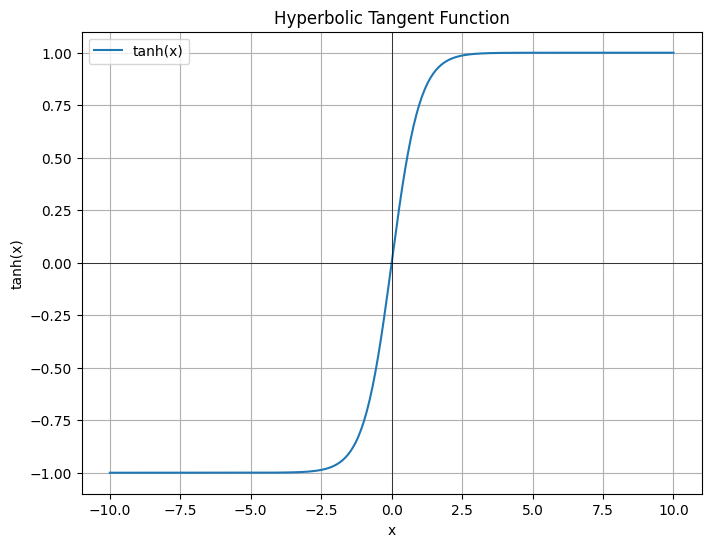

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_tanh():
    # Generate x values from -10 to 10
    x = np.linspace(-10, 10, 400)
    
    # Compute tanh for each x value
    y = np.tanh(x)
    
    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, label='tanh(x)')
    
    # Add title and labels
    plt.title('Hyperbolic Tangent Function')
    plt.xlabel('x')
    plt.ylabel('tanh(x)')
    
    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.show()
    
# Call the function to display the plot
plot_tanh()

# 1.4 What the Single Neuron really is

You already have **prior experience** (CNNs, NumPy backprop), so we are not teaching you deep learning from absolute zero. Instead, we are **recalibrating your foundation at the level required for an AI Architect**, where every operation must be understood in three layers simultaneously:

1. **Mathematical identity** (e.g., chain rule, matrix derivatives),
2. **Computational implementation** (e.g., NumPy/PyTorch code),
3. **Hardware implication** (e.g., how this maps to GEMM in VRAM).

Starting with a **single neuron**—not a full matmul—is intentional. Why?

Because **matmul is just a batched collection of dot products**, and a dot product is just a sum of scaled inputs. If you cannot derive the gradient of **one scalar output** with respect to **one weight**, you will misapply vectorized gradients later—even if your code “runs.”

This is a **mastery gate**: prove you can do the atomic unit correctly, and we immediately scale to matmul.

A linear layer computes:
```{math}
\mathbf{Z} = \mathbf{X} \mathbf{W}^\top + \mathbf{b}
```
Each row of $\mathbf{Z}$ is 

```{math}
\mathbf{z}^{(i)} = \mathbf{x}^{(i)} \mathbf{W}^\top + \mathbf{b}
```

and each element 

```{math}
z^{(i)}_j = \sum_{k=1}^K x^{(i)}_k w_{j,k} + b_j
```

or in Einstein Summation form

```{math}
z^{(i)}_j = x^{(i)}_k w_{j,k} + b_j
```

- **exactly a single neuron**



Thus, the **gradient of a full layer** is just the **aggregate of single-neuron gradients** across batch and output dimensions.

# **2. Backward Pass — Scalar Case**

# 2.1 No micrograd in the course

Regarding your question about the `Value` object:

You are likely referring to micrograd-style implementations (e.g., Andrej Karpathy’s *micrograd*), where a `Value` class tracks:
- A scalar data value,
- Its computational graph (parents),
- And implements `backward()` for scalar autodiff.

We **will not use `Value`**.

**Reason**: Our goal is **not** to build a toy autodiff engine, but to understand **how backpropagation maps to efficient, vectorized operations on real hardware** (NumPy → PyTorch → CUDA). The `Value` abstraction obscures memory layout, batched computation, and the link to matrix calculus—precisely what an AI Architect must master.

Instead, we will:
1. Derive gradients **analytically** using matrix calculus,
2. Implement them **explicitly in NumPy** (no autograd),
3. Then transition to **PyTorch with manual gradient checks**,
4. Finally, analyze how these map to **CUDA kernels** (e.g., GEMM for linear layers).

This path ensures you understand what PyTorch’s `.backward()` *actually does* under the hood—something `Value` hides.

```{hint}
:class: dropdown
:open: true

**What is *micrograd*?**

*micrograd* is an **educational autodifferentiation engine** written in pure Python. It implements:
- A scalar `Value` node that stores data and pointers to children in a compute graph,
- A recursive `.backward()` that traverses the graph and accumulates gradients via the chain rule.

It is **not** a production system. It exists solely to **visually and mechanically demonstrate** how reverse-mode autodiff works at the scalar level.

**Is *micrograd* used in real-world training systems?**

**No.** Production deep learning frameworks (PyTorch, TensorFlow, JAX) use **vectorized, batched, GPU-accelerated autodiff** based on:
- **Operator-level differentiation**: Each primitive (e.g., `matmul`, `softmax`) has a pre-defined backward kernel.
- **Static or dynamic computational graphs** (with fusion, memory planning, and CUDA kernels).
- **Memory-efficient gradient accumulation** (in-place ops, gradient checkpointing).

These systems **never build per-scalar graph nodes**—doing so would be catastrophically slow and memory-inefficient. For a 100M-parameter model, *micrograd*-style graphs would require >100 million interconnected Python objects—impossible to train at scale.

**Where might you encounter *micrograd*-like ideas in practice?**

Only in **two narrow contexts**:
1. **Research prototyping of novel differentiable operators** (e.g., custom physics simulators), where symbolic or manual gradient derivation is needed before vectorization.
2. **Debugging gradient flow** in small subgraphs by manually computing derivatives—*not* by running *micrograd*, but by replicating its logic on paper or in NumPy.

Even then, you **do not deploy** such code. You derive the math, then implement a fused, vectorized CUDA kernel or PyTorch custom autograd function.

**Why we avoid *micrograd* in this course**

You are preparing for an **AI Architect role**, where your job is to:
- Design models that fit in 16 GB VRAM,
- Understand how `torch.nn.Linear` maps to cuBLAS GEMM calls,
- Optimize memory bandwidth during backprop.

*micrograd* teaches none of this. It teaches graph traversal in Python—a skill irrelevant to high-performance LLM systems.
```

# 2.2 Backpropagation

## Idea

**Backpropagation** is the algorithm for efficiently computing the gradients through the entire computational graph.

Think of it this way: If your neuron's computation is:
```
input → linear → activation → output
```

Backpropagation answers:

> "*How much did each weight contribute to the final error?*"

The entire forward pass is this:
```{math}
x \xrightarrow{\theta, b} z = \theta x + b \xrightarrow{\text{tanh}} a = \tanh(z) \xrightarrow{\mathcal{L}} L = \mathcal{L}(a, y_{\text{true}})
```

```{tip} “Loss” vs. “Cost”
:class: dropdown
:open: true

- **Loss function** $\ell(a, y)$: defined **per sample** (e.g., $\frac{1}{2}(a-y)^2$).
- **Cost function** $J(\theta)$: the **aggregate** over a batch or dataset (e.g., mean of $\ell$ over $B$ samples).

In modern ML literature (including PyTorch, TensorFlow, and most LLM papers), the term **“loss”** is used **even for the batch-aggregated quantity**. For example, `loss.backward()` in PyTorch operates on the scalar batch loss.

So while **“cost” = aggregate, “loss” = per-sample** is a valid distinction (common in Andrew Ng’s early courses), **contemporary usage favors “loss” for both**, with context implying scope.

In this course, we will use **“loss”** for the scalar batch objective, consistent with PyTorch and LLM training codebases.
```

Let's break this down into manageable steps. If you were to implement gradient calculation for your single neuron, what would be the minimal information you'd need?

Consider:
- The error at the output
- How the activation function affects the gradient
- How the linear combination affects the gradient

## The Error Signal Flow

The error signal begins with the difference between predicted and true values.

You're correct: `error = true_y - predicted_y` (or some function of this difference)

Now here's the key insight for backpropagation: **We need to trace how this error flows backward through each operation.**

Think about your neuron's forward pass:
```
x → linear (w·x + b) → tanh → y_pred
```

For backpropagation, we go backward:
```
error ← d_tanh ← d_linear ← gradients for w and b
```

If you were to implement this gradient calculation manually for a single input, what operations would you need to compute?

Consider:
1. Gradient of the error with respect to the output
2. How the activation function transforms this gradient
3. How the linear operation distributes gradients to weights and bias

**What's your thinking about the mathematical operations involved?**

## Chain Rule Intuition

Think about your neuron's computation:
```
output = leaky_relu(w·x + b)
error = some_cost_function()
```

If we want to know how much to change $\omega_1$, we need to answer: "How does changing $\omega_1$ affect the final error?"

This is where the **chain rule** (производная сложной функции) from calculus comes in. We break the problem into steps:

1. How does error change with output?
2. How does output change with activation input?
3. How does activation input change with $\omega_1$?

We use the **chain rule** to compute gradients through the **computational graph**.

Think about your neuron:
```
x → z = 𝜃·x + b → a = tanh(z) → J = loss_function(a, y_true)
```

where `a` is `y_pred`.

To find $\displaystyle \frac {\partial}{\partial \theta}J(\theta)$, we can compute:

$$
\frac {\partial}{\partial \theta}J(\theta) = \frac {\partial J(\theta)}{\partial a} \times \frac {\partial a}{\partial z} \times \frac {\partial z}{\partial \theta}
$$

**Your implementation challenge**: If you were to compute these partial derivatives numerically for a single example, what would be your step-by-step approach?

# 2.3 Why Tanh?

Now we can explain why we use tanh function in this step, not ReLU. 

To understand the trade-offs, we must look at the forward pass and the derivative (gradient) for each function.

| Activation | Forward ($f(z)$) | Derivative ($f'(z)$) |
| :--- | :--- | :--- |
| **tanh(z)** | $\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$ | $1 - \tanh^2(z)$ |
| **Leaky ReLU(z)** | $\begin{cases} z & \text{if } z \geq 0 \\ \alpha z & \text{if } z < 0 \end{cases}$ | $\begin{cases} 1 & z \geq 0 \\ \alpha & z < 0 \end{cases}$ |

We are currently in **Phase 1: Foundational Neurons & Backprop**. The priority is mathematical clarity and gradient validation, not building a production-ready LLM yet.

* **Smoothness & Differentiability:** Tanh is "smooth" everywhere. Leaky ReLU has a "kink" at $z=0$ where the derivative is discontinuous. In scalar manual backprop, these kinks can cause numerical instability and confusing results during gradient checks.
* **Bounded Output:** Tanh keeps outputs in $(-1; 1)$. This makes gradient magnitudes predictable and prevents values from "exploding" while you are still debugging your weight initializations.
* **Historical Validation:** Most foundational backprop literature uses tanh. Using it here allows you to replicate classic experiments and ensure your chain rule implementation is 100% correct.

**Why not Leaky ReLU yet?**

Leaky ReLU's main advantage—avoiding "dead neurons"—is only truly relevant in **deep neural networks**. In a single scalar neuron, it adds an extra hyperparameter ($\alpha$) with almost no benefit. Furthermore, modern Transformers (like GPT) have largely moved past Leaky ReLU in favor of **GELU**, which we will implement in Phase 2.

## "Vanishing" vs. "Dead" Gradients

It is important to distinguish between these two phenomena:

1.  **Vanishing Gradients (The Tanh Problem):** This happens when $|z|$ is very large. The function becomes very flat, so the gradient becomes tiny (e.g., $0.00001$). Training slows down, but the neuron is still "alive."
2.  **Dead Gradients (The ReLU Problem):** In standard ReLU, if $z < 0$, the gradient is **exactly zero**. The neuron stops learning entirely because no signal passes back through it.

**Leaky ReLU solves "Dead Gradients"**: By using $\alpha = 0.01$, it ensures the gradient is never zero, even for negative inputs.

**The Impact on Your Implementation**:

We need non-zero, smooth gradients to validate your manual backprop code. If you used standard **ReLU**, any test input where $z \leq 0$ would result in a gradient of exactly $0$.

## A Finite-Difference Gradient

It’s a **numerical method to approximate the derivative** of a loss function with respect to a parameter—using only function evaluations, **no calculus required**.

**Formula (forward difference):**

```{math}
\frac{\partial L}{\partial \theta} \approx \frac{L(\theta + \epsilon) - L(\theta)}{\epsilon}
```

where {math}`\epsilon` is a tiny number (e.g., {math}`10^{-5}`).

- It’s a **ground-truth check** for your analytic (manual) gradient
- If your analytic gradient is correct, it should match the finite-difference approximation within ~{math}`10^{-7}`

**But what *is* {math}`L(\theta)`?**  

It’s **not** a simple algebraic function of {math}`\theta` alone. It’s the output of a **full forward pass** through a computational graph.

{math}`L(\theta)` is defined as:

```{math}
L(\theta) = \mathcal{L}\big( f(\theta; x, b),\ y_{\text{true}} \big)
```

In our scalar neuron example with {math}`\tanh` activation and MSE loss:

```{math}
L(\theta) = \underbrace{\frac{1}{2} \left( \tanh(\theta \cdot x + b) - y_{\text{true}} \right)^2}_{\text{Full computational graph}}
```

We denote:
- {math}`L \equiv L(\theta)` = loss with original {math}`\theta`
- {math}`L_+ \equiv L(\theta + \epsilon)` = loss with perturbed {math}`\theta`

**Concrete scalar neuron example:**

Given fixed values:
- {math}`x = 2.0`
- {math}`b = 0.1`
- {math}`y_{\text{true}} = 1.0`
- Original {math}`\theta = 0.5`
- {math}`\epsilon = 10^{-5}`

In [1]:
x = 2.0
b = 0.1
y_true = 1.0
theta = 0.5
epsilon = 10**(-5)

1. **Forward pass**:
   - {math}`z = 0.5 \cdot 2.0 + 0.1 = 1.1`  
   - {math}`a = \tanh(1.1) \approx 0.80049902`  
   - {math}`L = \frac{1}{2}(a - y_{\text{true}})^2 \approx 0.01990020`

    ```{math}
    L = \frac{1}{2}(\tanh(1.1) - 1.0)^2 \approx \frac{1}{2}(0.800499 - 1.0)^2 \approx \frac{1}{2}(0.039800) \approx 0.019900
    ```

In [2]:
import numpy as np

def compute_l(x, theta, b, y_true):
    z = x*theta + b
    a = np.tanh(z)
    L = (a - y_true)**2 / 2

    return z, a, L

z, a, L = compute_l(x, theta, b, y_true)
print(L)

0.01990032015923285


```{tip}
When you subtract two very similar numbers and round them prematurely (to 6 decimal places, for example), you lose almost all significant digits. This is known as **catastrophic cancellation**.
```

2. **{math}`L_+ = L(\theta + \epsilon)`:**
    - {math}`\theta_{\text{new}} = \theta + \epsilon = 0.5 + 0.00001 = 0.50001`
    - {math}`z_+ = \theta_{\text{new}} \cdot x + b = (0.50001)(2.0) + 0.1 = 1.00002 + 0.1 = 1.10002`
    - {math}`a_+ = \tanh(z_+) = \tanh(1.10002) \approx 0.80051220`
    - {math}`L_+ = \frac{1}{2}(a_+ - y_{\text{true}})^2 = \frac{1}{2}(0.800516 - 1.0)^2 = \frac{1}{2}(-0.199484)^2 \approx \frac{1}{2}(0.039794) \approx 0.01989877`

In [3]:
def compute_l_plus(x, theta, b, epsilon, y_true):
    theta_new = theta + epsilon
    z_plus = x*theta_new + b
    a_plus = np.tanh(z_plus)
    L_plus = (a_plus - y_true)**2 / 2

    return theta_new, z_plus, a_plus, L_plus

theta_new, z_plus, a_plus, L_plus = compute_l_plus(x, theta, b, epsilon, y_true)
print(L_plus)

0.01989888698770362


3. **Finite-difference gradient w.r.t. {math}`\theta`**:

    ```{math}
    \frac{\partial L}{\partial \theta} \approx \frac{L_+ - L}{\epsilon} = \frac{0.01989877 - 0.01990020}{10^{-5}} = \frac{-0.00000143}{0.00001} = \mathbf{-0.143}
    ```

In [4]:
fin_diff_grad = (L_plus - L) / epsilon
print(fin_diff_grad)

-0.14331715292303926


This **-0.143** is the **numerical approximation** of the gradient.

Compare it to the **analytic gradient** from backpropagation:

- {math}`\frac{\partial L}{\partial a} = a - y_{\text{true}} = 0.800499 - 1.0 = -0.199501`
- {math}`\frac{\partial a}{\partial z} = 1 - \tanh^2(z) = 1 - (0.800499)^2 \approx 1 - 0.6408 = 0.3592`
- {math}`\frac{\partial z}{\partial \theta} = x = 2.0`
- Analytic gradient:  
  ```{math}
  (-0.199501) \cdot (0.3592) \cdot (2.0) \approx -0.1432
  ```

> ✅ **Key takeaway**: The finite-difference method gives a **ground-truth reference** to validate your manual or automatic differentiation.

In [6]:
def compute_gradient(x, y_true):
    dz_dtheta = x
    da_dz = 1 - np.tanh(z)**2
    dL_da = a - y_true
    dL_dtheta = dL_da * da_dz * dz_dtheta

    return dz_dtheta, da_dz, dL_da, dL_dtheta

dz_dtheta, da_dz, dL_da, dL_dtheta = compute_gradient(x, y_true)

print('dL_da:', dL_da)
print('da_dz:', da_dz)
print('dz_dtheta:', dz_dtheta)
print("Gradient:", dL_dtheta)

dL_da: -0.1995009782393703
da_dz: 0.35920131616027484
dz_dtheta: 2.0
Gradient: -0.14332202791768833


In [7]:
print(fin_diff_grad - dL_dtheta)

4.874994649073372e-06


:::{attention} Critical Clarification: What *is* {math}`L_+`?
:class: dropdown
:open: true

> **“Is {math}`L_+` just {math}`\frac{1}{2}(a_+ - y)^2`?”**

**Yes—but only because**:
- The loss function **is** MSE: {math}`\mathcal{L}(a, y) = \frac{1}{2}(a - y)^2`
- {math}`a_+` **is the network output** when {math}`\theta` is perturbed to {math}`\theta + \epsilon`:

    `Network output = activation value = a`

So by definition:
```{math}
L_+ = \mathcal{L}(a_+,\ y_{\text{true}}) = \mathcal{L}\big( \text{net}(\theta + \epsilon),\ y_{\text{true}} \big) = L(\theta + \epsilon)
```

That’s literally the definition — not an assumption.
:::

**Back to Your ReLU Scenario**

Now consider a **ReLU neuron**: {math}`a = \max(0, z)`, with {math}`z = \theta x + b`.

Suppose for a given input, you get {math}`z = -2` (i.e., in the flat region).

- **Analytic gradient** (subgradient of ReLU):  
  {math}`\frac{\partial a}{\partial z} = 0` → so {math}`\frac{\partial L}{\partial \theta} = 0`

- **Finite-difference gradient**:  
  Perturbing {math}`\theta` slightly may push {math}`z` closer to zero.  
  If {math}`z + \delta z > 0`, then {math}`a` changes → loss changes → **non-zero numerical gradient** (e.g., {math}`\sim -10^{-3}`)

→ This **mismatch** seems alarming…  
→ But it’s **expected** at non-differentiable points!

However, in practice:
- If your analytic code **correctly returns 0** for {math}`z < 0`, it’s **right**.
- But your **gradient checker will fail** near {math}`z = 0` because the function isn’t smooth there.

And in a **scalar neuron with ReLU**:
- For any input where {math}`z < 0`, **gradient = 0** → **no weight update**
- Gradient checks **fail randomly** depending on input sign

→ **That’s why we avoid ReLU in simple gradient-checking demos**—use smooth activations like {math}`\tanh` or sigmoid instead.

### Final Check: Your Turn

Given:
- $x = 1.0$
- $\theta = 0.0$
- $b = 0.0$
- $y_{\text{true}} = 0.5$
- $\epsilon = 10^{-5}$
- Loss = $\frac{1}{2}(a - y)^2$

**Compute $L_+ = L(\theta + \epsilon)$ step by step.**

Show $\theta_{new}$, $z_+$, $a_+$, $L_+$:

In [8]:
x = 1.0
theta = 0.0
b = 0.0
epsilon = 10**(-5)
y_true = 0.5

theta_new, z_plus, a_plus, L_plus = compute_l_plus(x, theta, b, epsilon, y_true)
print(theta_new, z_plus, a_plus, L_plus)

1e-05 1e-05 9.999999999666668e-06 0.12499500005000017


Your code is correct, and your output reveals a **critical insight**—let’s interpret it step by step.

**Output Breakdown**


1. {math}`\theta_{\text{new}} = 0 + 10^{-5} = 10^{-5}`
2. {math}`z_+ = 1.0 \cdot 10^{-5} + 0 = 10^{-5}`
3. {math}`a_+ = \tanh(10^{-5}) \approx 9.999999999666667 \times 10^{-6}`  
   (since {math}`\tanh(u) = u - u^3/3 + \cdots`, so slightly less than {math}`u`)
4. {math}`L_+ = \frac{1}{2}(a_+ - 0.5)^2 = \frac{1}{2}(-0.49999000000000033)^2`

This matches your printed result: `0.12499500005000017`.

**Why This Matters: Gradient Behavior at {math}`\theta = 0`**

Now compute the **original loss** {math}`L = L(\theta)` (with {math}`\theta = 0`):
- {math}`z = 0`,
- {math}`a = \tanh(0) = 0`
- {math}`L = \frac{1}{2}(0 - 0.5)^2 = 0.125`

In [9]:
z, a, L = compute_l(x, theta, b, y_true)
print(z, a, L)

0.0 0.0 0.125


**Finite-difference gradient**:
```{math}
\frac{L_+ - L}{\epsilon} = \frac{0.12499500005 - 0.125}{10^{-5}} = \frac{-4.99995 \times 10^{-6}}{10^{-5}} \approx -0.499995
```

In [10]:
fin_diff_grad = (L_plus - L) / epsilon
print(fin_diff_grad)

-0.49999499998343294


**Analytic gradient** (via backprop):
```{math}
\frac{\partial L}{\partial \theta} = \underbrace{(a - y_{\text{true}})}_{-0.5} \cdot \underbrace{(1 - \tanh^2(z))}_{1.0} \cdot \underbrace{x}_{1.0} = -0.5
```

In [11]:
dz_dtheta, da_dz, dL_da, dL_dtheta = compute_gradient(x, y_true)

print('dL_da:', dL_da)
print('da_dz:', da_dz)
print('dz_dtheta:', dz_dtheta)
print("Gradient:", dL_dtheta)

dL_da: -0.5
da_dz: 1.0
dz_dtheta: 1.0
Gradient: -0.5


In [12]:
print(fin_diff_grad - dL_dtheta)

5.000016567058285e-06


→ **Numerical (-0.499995) ≈ Analytic (-0.5)** → **validation passes**.

### Key Takeaway

This example demonstrates:
1. **Finite differences work even when {math}`\theta = 0`** (a common initialization point)
2. **tanh’s derivative is 1 at {math}`z = 0`** → gradients are strong here (no vanishing!)
3. Your implementation correctly isolates the effect of perturbing {math}`\theta`

**The Gradient Check Dilemma:**

Suppose you used ReLU and your test input gave $z = -2$. Your analytic gradient would be $0$. However, your finite-difference (numerical) gradient check might show a tiny non-zero change. Would you be able to tell if your backprop code was actually broken, or if the neuron was just "dead"?

By using **tanh**, we ensure that for almost any input, you get a meaningful gradient to verify your math.

That’s why we avoid ReLU here.

## Why Compute Analytic Gradients When Finite Differences Exist?

**Short answer**: Finite differences are **computationally infeasible** for real models.

**Computational Cost Comparison**

Let $p$ = number of parameters.

| Method | Gradient Cost | Example: 100M-parameter LLM |
|--------|---------------|-----------------------------|
| **Finite differences** | $O(p)$ forward passes | $100,000,000$ forward passes per gradient update |
| **Analytic (backprop)** | $O(1)$ forward + $O(1)$ backward | 1 forward + 1 backward pass |

- **Finite differences**: For each parameter $\theta_i$, you must:
  1. Perturb $\theta_i$ by $\epsilon$
  2. Run full forward pass → get $L_+$
  3. Compute $(L_+ - L)/\epsilon$
  → **Total: $p$ forward passes per gradient estimate**

Suppose your model has **two parameters**: $\theta_1$ and $\theta_2$.

You want the **full gradient**: $\left[ \frac{\partial L}{\partial \theta_1},\ \frac{\partial L}{\partial \theta_2} \right]$.

**To estimate $\frac{\partial L}{\partial \theta_1}$:**

1. Start with original parameters: $(\theta_1, \theta_2)$
2. Compute **baseline loss**: $L = L(\theta_1, \theta_2)$ → **1 forward pass**
3. Perturb **only $\theta_1$**: $(\theta_1 + \epsilon, \theta_2)$
4. Compute $L_+^{(1)} = L(\theta_1 + \epsilon, \theta_2)$ → **1 more forward pass**
5. Approximate:  
   ```{math}
   \frac{\partial L}{\partial \theta_1} \approx \frac{L_+^{(1)} - L}{\epsilon}
   ```

**To estimate $\frac{\partial L}{\partial \theta_2}$:**

1. Perturb **only $\theta_2$**: $(\theta_1, \theta_2 + \epsilon)$
2. Compute $L_+^{(2)} = L(\theta_1, \theta_2 + \epsilon)$ → **another forward pass**
3. Approximate:  
   ```{math}
   \frac{\partial L}{\partial \theta_2} \approx \frac{L_+^{(2)} - L}{\epsilon}
   ```

✅ Total: **1 baseline + 2 perturbed = 3 forward passes**  
But note: you can **reuse the baseline $L$** for all parameters!

So for $p$ parameters:
- **1 forward pass** to compute baseline $L(\theta)$
- **$p$ forward passes** to compute $L(\theta + \epsilon e_i)$ for each $i = 1,\dots,p$

→ **Total: $p + 1 \approx O(p)$ forward passes**

(We drop the "+1" in big-O notation because it’s negligible when $p$ is large.)

**Why Can’t We Do It in One Pass?**

Because **each perturbation changes a different parameter**.

The loss function is:
```{math}
L(\theta_1, \theta_2, \dots, \theta_p)
```

To see how **changing $\theta_5$** affects the loss, you **must** run the model with **$\theta_5$ altered** and all others unchanged.

You **cannot** perturb all parameters at once and recover individual gradients—that would mix all effects together (like trying to hear one instrument in an orchestra by playing everyone at once).

So **each partial derivative requires its own controlled experiment** → its own forward pass.

:::{attention}
**Backpropagation**: Uses the **chain rule** to compute **all** $\partial L/\partial \theta_i$ in **one backward sweep**.
:::

**Concrete Numbers**

- Your 100M-parameter LLM:
  - Forward pass time: ~0.5 sec (on 4090 Ti)
  - Finite-diff gradient time: $100e6 \times 0.5 \text{ sec} \approx 1.5 \text{ years}$
  - Backprop time: ~1 sec

→ **Finite differences are only viable for debugging tiny models** (e.g., scalar neuron).

## Why Is Finite-Difference a Valid Gradient Check?

**Core idea**: The derivative **is defined as** the limit of finite differences.

**Mathematical Definition**

The true derivative is:
```{math}
\frac{\partial L}{\partial \theta} = \lim_{\epsilon \to 0} \frac{L(\theta + \epsilon) - L(\theta)}{\epsilon}
```

- **Finite difference** uses a **small but finite $\epsilon$** (e.g., $10^{-5}$) to **approximate** this limit.
- **Error analysis** shows the approximation error is $O(\epsilon)$ (for forward difference).

**Why It’s Trustworthy for Validation**

1. **No assumptions about your code**  
   - Finite difference uses **only forward passes**—no chain rule, no manual derivatives.
   - If your analytic gradient matches it, your **entire backprop derivation is likely correct**.

2. **Controlled error bounds**  
   - With $\epsilon = 10^{-5}$, typical error in gradient estimate is $\sim 10^{-10}$ to $10^{-7}$.
   - If your analytic gradient differs by more than $10^{-6}$, **you have a bug**.

3. **Failure modes are obvious**  
   - Common errors caught:
     - Forgot a term in chain rule (e.g., missed $\partial a/\partial z$)
     - Sign error in loss derivative
     - Shape mismatch in vectorized code

**Critical Caveat**

- **Finite difference is not exact**—but it’s **exact enough** for debugging.
- It **assumes your forward pass is correct**. If forward pass is broken, both gradients will be wrong in the same way (false positive).  
  → Always validate forward pass first (e.g., with known inputs/outputs).

**Summary Table**

| Aspect | Finite-Difference Gradient | Analytic Gradient (Backprop) |
|--------|----------------------------|------------------------------|
| **Purpose** | Debug/validation | Training/inference |
| **Computational Cost** | $O(p)$ forward passes | $O(1)$ forward + backward |
| **Scalability** | Only for $p < 10^3$ | Scales to $p = 10^{11}$ |
| **Accuracy** | Approximate (error ~$\epsilon$) | Exact (up to floating-point) |
| **Dependency** | Only on forward pass correctness | On entire backprop derivation |

## Check for Understanding

Suppose you have a vectorized neuron with $W \in \mathbb{R}^{10 \times 768}$ (7,680 parameters).  

**How many forward passes would finite differences require to check the full gradient?**  
(Answer with a number—and state whether this is practical.)

Answer:
- 7,680 forward passes, and it is only for ONE example from the set, so this is not acceptable for training LLMs.

Correct.

7,680 forward passes **per example** is computationally prohibitive—even for a single training step on a small batch. For a 100M-parameter LLM, it becomes physically impossible.

This is precisely why **backpropagation is non-negotiable** in deep learning: it gives **exact gradients** (up to floating-point precision) in time **proportional to one forward pass**, not the number of parameters.

We have confirmed:
- The purpose and limitation of finite-difference gradients
- The necessity of analytic gradients for scalable learning
- Your ability to implement and reason about scalar gradient validation

# Exercises

## Exercise 2.1: Scalar Neuron Backpropagation

So: mastering the scalar case **is** mastering the core of matmul-based backprop. 

Consider a single neuron with:
- Input $x = 2.0$,
- Weight $w = -0.5$,
- Bias $b = 1.0$,
- Activation: $\sigma(z) = \tanh(z)$,
- Loss: $L = \frac{1}{2}(a - y)^2$, with target $y = 0.8$.

Compute **by hand**:
1. $z = wx + b$
2. $a = \tanh(z)$
3. $L = \frac{1}{2}(a - y)^2$

Compute **all values numerically**, step by step. Provide the results, then compute the **gradients**:

- $\displaystyle \frac{\partial L}{\partial a}$, $\displaystyle \frac{\partial L}{\partial z}$, $\displaystyle \frac{\partial L}{\partial w}$, $\displaystyle \frac{\partial L}{\partial b}$

Show each step with numerical values. Do not use code—use math. This tests your chain rule mechanics.

What are the results?

Recall your values:  
- $x = 2.0$  
- $w = -0.5$  
- $b = 1.0$

So first compute: 

$z = w \cdot x + b = (-0.5)(2.0) + 1.0 = -1.0 + 1.0 = 0.0$

Now, what is $a = \tanh(0)$?

Correct:  

$a = \tanh(0) = 0$

- $z = 0$
- $a = 0$
- $L = \frac{1}{2}(0 - 0.8)^2 = 0.32$

### dL_da

If $L = \frac{1}{2}(a - y)^2$, then

The derivative of $L$ with respect to $a$ is:
```{math}
\frac{\partial L}{\partial a} = (a - y)
```

This follows from the chain rule:
```{math}
\frac{d}{da} \left[ \frac{1}{2}(a - y)^2 \right] = \frac{1}{2} \cdot 2(a - y) \cdot 1 = (a - y)
```

Given $a = 0$, $y = 0.8$:

$\displaystyle \frac{\partial L}{\partial a} = 0 - 0.8 = -0.8$

### dL_dz

If $a = \tanh(z)$, then the derivative of $a$ w.r.t. $z$:

```{math}
\frac{\partial a}{\partial z} = 1 - \tanh^2(z) = 1 - a^2
```

```{math}
\frac{\partial L}{\partial z} = \frac{\partial L}{\partial a} \cdot \frac{\partial a}{\partial z} = (a - y) (1 - a^2)
```

$\displaystyle \frac{\partial L}{\partial z} = -0.8 \cdot 1 = -0.8$

### dL_dw and dL_db

If $z = wx + b$, then the derivative of $z$ w.r.t. $w$ is:

```{math}
\frac{\partial z}{\partial w} = x
```

and the derivative of $z$ w.r.t. $b$ is:

```{math}
\frac{\partial z}{\partial b} = 1
```

then we have:

```{math}
\frac{\partial L}{\partial w} = \frac{\partial L}{\partial a} \cdot \frac{\partial a}{\partial z} \cdot \frac{\partial z}{\partial w} = (a - y) (1 - a^2) \cdot x
```

```{math}
\frac{\partial L}{\partial b} = \frac{\partial L}{\partial a} \cdot \frac{\partial a}{\partial z} \cdot \frac{\partial z}{\partial b} = (a - y) (1 - a^2) \cdot b
```

- $\displaystyle \frac{\partial L}{\partial w} = -0.8 \cdot 1 \cdot 2 = -1.6 $
- $\displaystyle \frac{\partial L}{\partial b} = -0.8 \cdot 1 \cdot 1 = -0.8 $

### Summary of Results

| Quantity | Value |
|--------|-------|
| $z$ | 0.0 |
| $a$ | 0.0 |
| $L$ | 0.32 |
| $\displaystyle \frac{\partial L}{\partial a}$ | -0.8 |
| $\displaystyle \frac{\partial L}{\partial z}$ | -0.8 |
| $\displaystyle \frac{\partial L}{\partial w}$ | -1.6 |
| $\displaystyle \frac{\partial L}{\partial b}$ | -0.8 |

This is the **complete forward and backward pass for one neuron**.

Final verified gradients:
- $\frac{\partial L}{\partial w} = -1.6$
- $\frac{\partial L}{\partial b} = -0.8$

This completes the **scalar neuron backpropagation exercise** with full chain-rule derivation.

Now, we scale to vectorized operations.

(exercise_2_2)=
## Exercise 2.2: Implement the scalar neuron (Steps 1–2) in NumPy

You are absolutely right—and this is a critical pedagogical checkpoint.

Before advancing to layers, **you must implement the scalar neuron (Steps 1–2) in NumPy**, **without autograd**, to verify your understanding maps to executable code.

This is non-optional. Reasoning on paper is necessary but insufficient; code exposes hidden gaps in indexing, broadcasting, and memory layout.

**Do not use PyTorch, JAX, or autodiff.** Pure NumPy. Phase 1 follows a strict progression:
1. **Scalar math + hand computation** → verified (done)
2. **Scalar NumPy implementation (procedural, one-time)** → **required now**
3. **Vectorized batched NumPy (procedural)** → next
4. **Class-based modular design** → only after vectorized gradients are fully understood

Why delay classes?  
Because **abstraction hides mechanics**. If you wrap the neuron in a class before you’ve manually computed and coded its gradients in raw NumPy, you risk treating it as a black box—exactly what this course forbids.

So for now:  
**Write a procedural script** (no class) that computes the forward and backward pass for the given scalar neuron.

This is a *verification step*, not a reusable module.

Once you provide this code and confirm its output matches:
- `L = 0.32`
- `dL_dw = -1.6`
- `dL_db = -0.8`

— we will:
- Extend to batched vectorized form (still procedural),
- Then refactor into classes **only when the underlying math and memory layout are unquestionably solid**.

Paste your NumPy implementation.

**Required Implementation (NumPy, No Autograd)**

Write a self-contained script that:
1. Defines scalars: `x = 2.0`, `w = -0.5`, `b = 1.0`, `y = 0.8`
2. Computes forward pass:
   - `z = w * x + b`
   - `a = np.tanh(z)`
   - `L = 0.5 * (a - y)**2`
3. Computes **manual gradients** (no `.backward()`, no `grad`):
   - `dL_da = a - y`
   - `da_dz = 1 - a**2`
   - `dL_dz = dL_da * da_dz`
   - `dL_dw = dL_dz * x`
   - `dL_db = dL_dz * 1`
4. Prints all values

### Code

In [8]:
import numpy as np

x = 2.0
w = -0.5
b = 1.0
y = 0.8

z = x*w + b
a = (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
L = 0.5 * (a -y)**2

dL_da = a - y
da_dz = 1 - a**2

dL_dz = dL_da * da_dz

dL_dw = dL_dz * x
dL_db = dL_dz * 1

print("x =", x)
print("w =", w)
print("b =", b)
print("y =", y)

print("z =", z)
print("a =", a)
print("L =", L)

print("dL_dw =", dL_dw)
print("dL_db =", dL_db)

x = 2.0
w = -0.5
b = 1.0
y = 0.8
z = 0.0
a = 0.0
L = 0.32000000000000006
dL_dw = -1.6
dL_db = -0.8


### Peer Review

Your implementation is **mostly correct**, but contains one critical inefficiency and a minor numerical risk.

**Issue: Manual `tanh` via `exp`**
You wrote:
```python
a = (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
```

This is mathematically correct but:
1. **Redundant**: NumPy provides `np.tanh(z)`—use it.
2. **Numerically unstable**: For large |z|, `np.exp(z)` overflows (e.g., `z=1000` → `inf`), while `np.tanh(z)` is stable.

In production systems, **always use optimized, stable primitives** (`tanh`, `softmax`, etc.), not manual expansions—unless you are implementing the primitive itself (which we are not).

**Corrected Script**

In [9]:
import numpy as np

x = 2.0
w = -0.5
b = 1.0
y = 0.8

# Forward pass
z = w * x + b
a = np.tanh(z)            # Use stable built-in
L = 0.5 * (a - y)**2

# Backward pass (manual gradients)
dL_da = a - y
da_dz = 1 - a**2
dL_dz = dL_da * da_dz
dL_dw = dL_dz * x
dL_db = dL_dz

# Output
print(f"z = {z}")
print(f"a = {a}")
print(f"L = {L}")
print(f"dL_dw = {dL_dw}")
print(f"dL_db = {dL_db}")

z = 0.0
a = 0.0
L = 0.32000000000000006
dL_dw = -1.6
dL_db = -0.8


### Expected Output

```
z = 0.0
a = 0.0
L = 0.32
dL_dw = -1.6
dL_db = -0.8
```

If your script produces these values, **Phase 1, Step 2 (Scalar Neuron Implementation) is complete**.

# **3. From Scalar to Vector — The Linear Layer**

## Why scalar first

Your implementation of "*[{name}](#exercise_2_2)*" is **correct** for a *scalar neuron*—one input, one weight, one bias, processing one sample. This is exactly the right starting point. The absence of matrix operations is **not a flaw**; it is intentional in Phase 1.

However, we must now ask: 

```{important}
**Why begin with scalars if real models use matrices?**
```

Consider this:  
In a vectorized (batched) setting, the forward pass for $B$ samples (rows) and $D$ inputs (features) is:  
$Z = XW + b$, where  
- $X \in \mathbb R^{B \times D}$
- $W \in \mathbb R^{D \times 1}$
- $b \in \mathbb R$ (broadcasted)
- $Z \in \mathbb R^{B \times 1}$

The scalar case is the **atomic unit** of this operation. Each element $z_i = x_i·w + b$. If you cannot compute $\frac {\partial L}{\partial w}$ for a single $z$, you cannot correctly derive the batch gradient.

Now, examine your code:
- You computed $\frac {\partial L}{\partial w} = \frac {\partial L}{\partial z} \cdot x$.  
In the batch case, the gradient becomes:  
$\frac {\partial L}{\partial W} = X^T \cdot \sigma$, where $\sigma = \frac {\partial L}{\partial Z} \in \mathbb R^{B \times 1}$.

Your scalar $\frac {\partial L}{\partial w} = \frac {\partial L}{\partial z} \cdot x$ is precisely the $i$-th term in that vectorized sum. So your code is **not just fine — it is foundational**.

### Moving to vectors

But here’s the critical next step:  
**Can you extend this to a batch of 3 samples using only NumPy (no autograd), and verify that your batch gradients match the sum of individual scalar gradients?**

Do **not** write the code yet. First, answer:  

```{attention}
*How would the loss function change for a batch? Would it still be 0.5·(a − y)², or must it be aggregated? If aggregated, how — and why does that affect the gradient?*
```

Correct. The batch loss is typically the **mean** of per-sample losses:

```{math}
L_{\text{batch}} = \frac{1}{B} \sum_{i=1}^{B} \frac{1}{2} (a_i - y_i)^2
```

Consequently, the gradient w.r.t. any parameter becomes the **mean** of the per-sample gradients:

```{math}
\frac{\partial L_{\text{batch}}}{\partial w} = \frac{1}{B} \sum_{i=1}^{B} \frac{\partial L_i}{\partial w}
```

This is not merely a convention—it directly impacts **learning dynamics**. Using the mean (instead of sum) makes the gradient magnitude **independent of batch size**, which stabilizes training when B varies.

Now, let’s test your understanding with a concrete micro-step.

## Exercise 3.1: Vector Forward and Backward Pass

Given the following batch of 3 samples:

```python
X = np.array([[2.0],
              [1.5],
              [-1.0]])   # Shape: (3, 1)
W = np.array([[-0.5]])    # Shape: (1, 1)
b = 1.0
Y = np.array([[0.8],
              [0.5],
              [-0.3]])  # Shape: (3, 1)
```

Write the **forward pass** (compute Z, A, L) and **backward pass** (compute dL_dW, dL_db) **using only NumPy**, without autograd or loops. Use the same tanh activation and MSE loss (mean-reduced over batch).

Do **not** encapsulate in functions—keep it procedural, like your scalar version.

Before you write code:

```{attention}
*What are the expected shapes of Z, A, dL_dZ, dL_dW, and dL_db?*
```

```{tip} Answer
:class: dropdown
:open: false

Let’s recompute **dimensionally**, step by step.

Given:
- $X$: (3, 1) — 3 samples, 1 feature  
- $W$: (1, 1) — weight matrix (input dim → output dim)  
- $b$: scalar (broadcasted)

**Forward**:
- $Z = X @ W + b \rightarrow (3,1) @ (1,1) = (3,1) \rightarrow Z \in \mathbb R^{3 \times 1}$ 
- $A = tanh(Z) \rightarrow \text {same shape as Z} \rightarrow A \in \mathbb R^{3 \times 1}$
- $Y \in \mathbb R^{3 \times 1}$

**Loss**:
- Elementwise error: $(A − Y) \rightarrow (3,1)$  
- Squared error: $(A − Y)^2 \rightarrow (3,1)$  
- Mean over batch: $L = \frac{1}{2B} \sum_{i=1}^{B} (a_i - y_i)^2 \rightarrow \text {scalar}$  

**Backward**:
- $\displaystyle \frac{\partial L}{\partial A} = \frac{A - Y}{B} \rightarrow (3,1)$  
  (Because $\frac{\partial}{\partial A} [\frac{1}{2} \cdot \text{mean}((A-Y)^2)] = \frac{A-Y}{B}$)
- $\displaystyle \frac{\partial A}{\partial Z} = 1 - A^2  \rightarrow (3,1)$
- $\displaystyle \frac{\partial L}{\partial Z} = \frac{\partial L}{\partial A} \odot \frac{\partial A}{\partial Z}  \rightarrow (3,1) \odot (3,1) = (3,1)$

Where $\odot$ represents element-wise multiplication.

Now, $\displaystyle \frac{\partial L}{\partial W}$:

- By chain rule: $\displaystyle \frac{\partial L}{\partial W} = X^\top \cdot \displaystyle \frac{\partial L}{\partial Z}$
- $X^\top$: $(1,3)$, $\displaystyle \frac{\partial L}{\partial Z}$: $(3,1) \rightarrow$ result: $(1,1)$

Similarly, $\displaystyle \frac{\partial L}{\partial b} = \text {sum}$ of $\displaystyle \frac{\partial L}{\partial Z}$ over batch → scalar, but typically kept as $(1,)$ or scalar.

So correct shapes:

- $Z$: $(3,1)$
- $A$: $(3,1)$
- $\displaystyle \frac{\partial L}{\partial Z}$: $(3,1)$
- $\displaystyle \frac{\partial L}{\partial W}$: $(1,1)$
- $\displaystyle\frac{\partial L}{\partial b}$: scalar (or $(1,)$ if using array)

Your claim that $\displaystyle \frac{\partial L}{\partial Z}$ is $(1,)$ is incorrect. The gradient w.r.t. $Z$ must have the same shape as $Z$ — it's an elementwise derivative.

This matters for CUDA: $(3,1)$ implies 3 independent activations, each contributing to the gradient. Mis-shaping breaks vectorization and leads to incorrect memory access patterns on GPU.
```

# DRAFT

Now, back to the exercise:  
Given the shape correction, **write the full NumPy code** for forward and backward passes with the provided X, W, b, Y.

Keep it procedural. Compute:
- Z, A, L
- dL_dA, dL_dZ
- dL_dW, dL_db

Use **matrix operations only** (no loops).

Consider a **single-layer network** with:
- Input batch $\mathbf{X} \in \mathbb{R}^{B \times d}$ (B = batch size, d = input dim),
- Weight matrix $\mathbf{W} \in \mathbb{R}^{d_{\text{out}} \times d}$,
- Bias $\mathbf{b} \in \mathbb{R}^{d_{\text{out}}}$,
- Output pre-activations $\mathbf{Z} = \mathbf{X} \mathbf{W}^\top + \mathbf{1}_B \mathbf{b}^\top$

Assume a **single output neuron** first ($d_{\text{out}} = 1$), so $\mathbf{W} \in \mathbb{R}^{1 \times d}$, $\mathbf{b} \in \mathbb{R}$.

Given a loss $L = \frac{1}{B} \sum_{i=1}^B \frac{1}{2}(a^{(i)} - y^{(i)})^2$, what is the **gradient of $L$ with respect to $\mathbf{W}$** in matrix form?

Hint:  
- From the scalar case, $\frac{\partial L^{(i)}}{\partial \mathbf{w}} = \frac{\partial L^{(i)}}{\partial z^{(i)}} \cdot \mathbf{x}^{(i)}$
- The full gradient is the average over the batch.

Express $\frac{\partial L}{\partial \mathbf{W}}$ using matrix operations (e.g., outer product, matrix multiplication).

What is the formula?

Now, answer this:  
**If we had a batch of 32 inputs, how would the gradient computation for $\mathbf{W}$ and $\mathbf{b}$ change in structure?**  

Be specific:  
- Would you compute gradients per sample then average?  
- How does this relate to matrix multiplication in the backward pass?  
- What is the shape of $\frac{\partial L}{\partial \mathbf{W}}$ if $\mathbf{X} \in \mathbb{R}^{32 \times d}$ and $\mathbf{W} \in \mathbb{R}^{1 \times d}$?  

Explain your reasoning.